# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

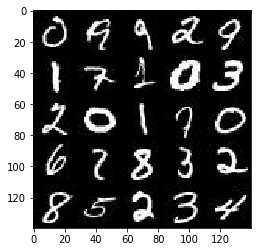

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

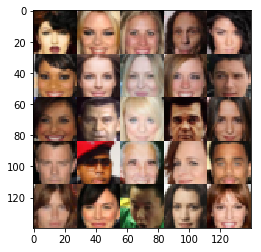

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name="input_real")
    input_fake = tf.placeholder(tf.float32, shape=[None, z_dim], name="input_fake")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    return input_real, input_fake, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False, alpha=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        
        n = images.get_shape()[1:]
        out_flat = n[0]*n[1]*n[2]
        # Input layer is 28x28x3  
        
        conv_layer1 = tf.layers.conv2d(images, 64, (5,5), strides=2, padding='same', activation=None)
        out_conv_layer1 = tf.maximum(alpha*conv_layer1, conv_layer1)
        # now 14x14x64       
        
        conv_layer2 = tf.layers.conv2d(out_conv_layer1, 128, (5,5), strides=2, padding='same', use_bias=False, activation=None)
        batch_normalized_output2 = tf.layers.batch_normalization(conv_layer2, training = True)        
        out_conv_layer2 = tf.maximum(alpha*batch_normalized_output2, batch_normalized_output2)
        # now 7x7x128       

        conv_layer3 = tf.layers.conv2d(out_conv_layer2, 256, (5,5), strides=2, padding='same', use_bias=False, activation=None)
        batch_normalized_output3 = tf.layers.batch_normalization(conv_layer3, training = True)        
        out_conv_layer3 = tf.maximum(alpha*batch_normalized_output3, batch_normalized_output3)
        # now 4x4x256       
    
        y = tf.reshape(out_conv_layer3, (-1, 4*4*256))
        logits = tf.layers.dense(y, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*1024, activation=None)          
        x1 = tf.reshape(x1, [-1, 2, 2, 1024])
        x1 = tf.layers.batch_normalization(x1, training = is_train)        
        x1 = tf.maximum(alpha*x1, x1)
        # now 4*4*512
  
        x2_ = tf.image.resize_nearest_neighbor(x1, size=(4,4))        
        x2_ = tf.layers.conv2d(x2_, 512, (5,5), padding='same', use_bias=False, activation=None)
        x2_ = tf.layers.batch_normalization(x2_, training = is_train)        
        x2_ = tf.maximum(alpha*x2_, x2_)
        # now 7*7*256


        x2 = tf.image.resize_nearest_neighbor(x2_, size=(7,7))        
        x2 = tf.layers.conv2d(x2, 256, (5,5), padding='same', use_bias=False, activation=None)
        x2 = tf.layers.batch_normalization(x2, training = is_train)        
        x2 = tf.maximum(alpha*x2, x2)
        # now 7*7*256
        
        x3 = tf.image.resize_nearest_neighbor(x2, size=(14,14))        
        x3 = tf.layers.conv2d(x3, 128, (5,5), padding='same', use_bias=False, activation=None)
        x3 = tf.layers.batch_normalization(x3, training = is_train)        
        x3 = tf.maximum(alpha*x3, x3)
        # now 14*14*128
         
        x4 = tf.image.resize_nearest_neighbor(x3, size=(28,28))  

        x4 = tf.layers.conv2d(x4, out_channel_dim, (5,5), padding='same', use_bias=False, activation=None)        
        # Output layer, 28x28x3
        logits = x4
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.5):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    real_d_out, real_d_out_logits = discriminator(input_real, reuse=False, alpha=alpha)
    fake_d_out, fake_d_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    real_d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_d_out_logits,
                                                                        labels=tf.ones_like(real_d_out)*(1-smooth)))
    
    fake_d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits,
                                                                        labels=tf.zeros_like(fake_d_out)))

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits,
                                                                        labels=tf.ones_like(fake_d_out)))

    d_loss = real_d_loss + fake_d_loss

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    all_var = tf.trainable_variables()    
    g_vars = [myvars for myvars in all_var if myvars.name.startswith("generator")]    
    d_vars = [myvars for myvars in all_var if myvars.name.startswith("discriminator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list= g_vars)
        d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list= d_vars)


    return d_train, g_train



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    alpha = 0.01
    show_every_n = 100
    print_every_n = 10
    steps = 0

    # Create the Model
    image_width, image_height, image_channels = data_shape[1], data_shape[2], data_shape[3]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim) 
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=alpha)        
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Start the Session and train
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
                # Rescale input to be between [-1,1] instead of [-0.5,0.5]
                batch_images = batch_images *2
                
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr: learning_rate})                
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr: learning_rate})
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                
                _ = sess.run(g_train_opt, feed_dict={input_z:batch_z, lr: learning_rate})


                if (steps % print_every_n == 0):
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z })
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...Step {}".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if (steps % show_every_n == 0):
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
        saver.save(sess, 'generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...Step 10 Discriminator Loss: 2.2139... Generator Loss: 1.6159
Epoch 1/2...Step 20 Discriminator Loss: 1.1271... Generator Loss: 1.5951
Epoch 1/2...Step 30 Discriminator Loss: 2.5589... Generator Loss: 6.4049
Epoch 1/2...Step 40 Discriminator Loss: 0.5242... Generator Loss: 2.5458
Epoch 1/2...Step 50 Discriminator Loss: 0.5788... Generator Loss: 2.6215
Epoch 1/2...Step 60 Discriminator Loss: 0.4478... Generator Loss: 3.7525
Epoch 1/2...Step 70 Discriminator Loss: 1.1069... Generator Loss: 1.8530
Epoch 1/2...Step 80 Discriminator Loss: 1.5480... Generator Loss: 0.5282
Epoch 1/2...Step 90 Discriminator Loss: 0.4479... Generator Loss: 3.6156
Epoch 1/2...Step 100 Discriminator Loss: 0.3632... Generator Loss: 5.1045


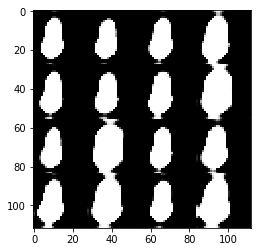

Epoch 1/2...Step 110 Discriminator Loss: 0.3853... Generator Loss: 3.3635
Epoch 1/2...Step 120 Discriminator Loss: 0.4207... Generator Loss: 3.2655
Epoch 1/2...Step 130 Discriminator Loss: 0.4883... Generator Loss: 2.2528
Epoch 1/2...Step 140 Discriminator Loss: 0.3996... Generator Loss: 4.4403
Epoch 1/2...Step 150 Discriminator Loss: 0.3978... Generator Loss: 3.8603
Epoch 1/2...Step 160 Discriminator Loss: 0.8347... Generator Loss: 7.7903
Epoch 1/2...Step 170 Discriminator Loss: 0.3952... Generator Loss: 6.6259
Epoch 1/2...Step 180 Discriminator Loss: 0.4415... Generator Loss: 7.1054
Epoch 1/2...Step 190 Discriminator Loss: 4.9284... Generator Loss: 7.6303
Epoch 1/2...Step 200 Discriminator Loss: 0.5278... Generator Loss: 4.8863


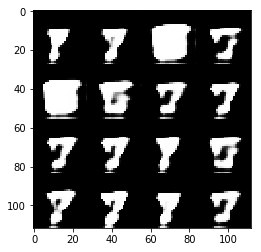

Epoch 1/2...Step 210 Discriminator Loss: 0.4001... Generator Loss: 4.6002
Epoch 1/2...Step 220 Discriminator Loss: 0.6441... Generator Loss: 1.7350
Epoch 1/2...Step 230 Discriminator Loss: 1.3898... Generator Loss: 0.5516
Epoch 1/2...Step 240 Discriminator Loss: 0.4685... Generator Loss: 3.5067
Epoch 1/2...Step 250 Discriminator Loss: 0.9053... Generator Loss: 1.3577
Epoch 1/2...Step 260 Discriminator Loss: 0.6774... Generator Loss: 1.8592
Epoch 1/2...Step 270 Discriminator Loss: 0.5558... Generator Loss: 2.1167
Epoch 1/2...Step 280 Discriminator Loss: 1.2522... Generator Loss: 0.6864
Epoch 1/2...Step 290 Discriminator Loss: 0.6701... Generator Loss: 1.7407
Epoch 1/2...Step 300 Discriminator Loss: 0.4682... Generator Loss: 2.7083


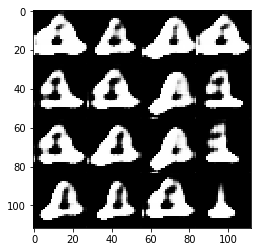

Epoch 1/2...Step 310 Discriminator Loss: 0.6854... Generator Loss: 2.0970
Epoch 1/2...Step 320 Discriminator Loss: 0.6192... Generator Loss: 2.4144
Epoch 1/2...Step 330 Discriminator Loss: 0.5046... Generator Loss: 2.9355
Epoch 1/2...Step 340 Discriminator Loss: 0.4626... Generator Loss: 2.3312
Epoch 1/2...Step 350 Discriminator Loss: 0.6123... Generator Loss: 2.0160
Epoch 1/2...Step 360 Discriminator Loss: 0.9306... Generator Loss: 0.9306
Epoch 1/2...Step 370 Discriminator Loss: 1.2058... Generator Loss: 1.1829
Epoch 1/2...Step 380 Discriminator Loss: 0.6845... Generator Loss: 1.5279
Epoch 1/2...Step 390 Discriminator Loss: 0.5464... Generator Loss: 2.4283
Epoch 1/2...Step 400 Discriminator Loss: 0.3825... Generator Loss: 4.2317


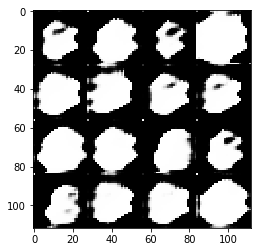

Epoch 1/2...Step 410 Discriminator Loss: 1.4729... Generator Loss: 3.8622
Epoch 1/2...Step 420 Discriminator Loss: 0.5818... Generator Loss: 2.4087
Epoch 1/2...Step 430 Discriminator Loss: 0.7096... Generator Loss: 2.9711
Epoch 1/2...Step 440 Discriminator Loss: 0.5505... Generator Loss: 5.0705
Epoch 1/2...Step 450 Discriminator Loss: 0.5505... Generator Loss: 2.6058
Epoch 1/2...Step 460 Discriminator Loss: 1.9315... Generator Loss: 5.8301
Epoch 2/2...Step 470 Discriminator Loss: 1.5190... Generator Loss: 0.7132
Epoch 2/2...Step 480 Discriminator Loss: 0.6020... Generator Loss: 2.2273
Epoch 2/2...Step 490 Discriminator Loss: 1.0797... Generator Loss: 3.9893
Epoch 2/2...Step 500 Discriminator Loss: 0.5290... Generator Loss: 2.5066


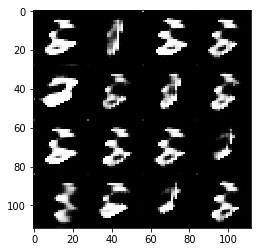

Epoch 2/2...Step 510 Discriminator Loss: 0.8812... Generator Loss: 1.0916
Epoch 2/2...Step 520 Discriminator Loss: 0.6682... Generator Loss: 3.4442
Epoch 2/2...Step 530 Discriminator Loss: 0.6769... Generator Loss: 2.4206
Epoch 2/2...Step 540 Discriminator Loss: 0.5351... Generator Loss: 2.5669
Epoch 2/2...Step 550 Discriminator Loss: 1.0393... Generator Loss: 1.0094
Epoch 2/2...Step 560 Discriminator Loss: 0.8951... Generator Loss: 1.7001
Epoch 2/2...Step 570 Discriminator Loss: 0.8951... Generator Loss: 3.7640
Epoch 2/2...Step 580 Discriminator Loss: 0.6295... Generator Loss: 3.4263
Epoch 2/2...Step 590 Discriminator Loss: 0.6740... Generator Loss: 2.0968
Epoch 2/2...Step 600 Discriminator Loss: 0.5516... Generator Loss: 2.2829


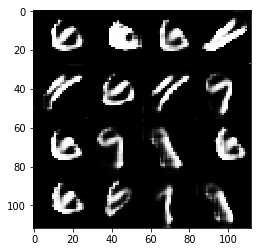

Epoch 2/2...Step 610 Discriminator Loss: 1.6257... Generator Loss: 1.9750
Epoch 2/2...Step 620 Discriminator Loss: 0.6974... Generator Loss: 2.4755
Epoch 2/2...Step 630 Discriminator Loss: 0.7632... Generator Loss: 1.4979
Epoch 2/2...Step 640 Discriminator Loss: 0.8725... Generator Loss: 1.6905
Epoch 2/2...Step 650 Discriminator Loss: 0.6338... Generator Loss: 1.8354
Epoch 2/2...Step 660 Discriminator Loss: 0.7252... Generator Loss: 2.0392
Epoch 2/2...Step 670 Discriminator Loss: 0.6693... Generator Loss: 1.8378
Epoch 2/2...Step 680 Discriminator Loss: 1.8498... Generator Loss: 5.1038
Epoch 2/2...Step 690 Discriminator Loss: 0.6605... Generator Loss: 1.9305
Epoch 2/2...Step 700 Discriminator Loss: 0.8900... Generator Loss: 1.4849


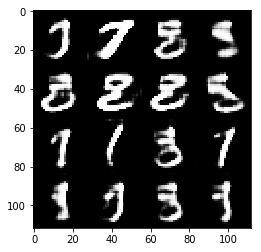

Epoch 2/2...Step 710 Discriminator Loss: 0.7595... Generator Loss: 2.5367
Epoch 2/2...Step 720 Discriminator Loss: 0.7540... Generator Loss: 3.3197
Epoch 2/2...Step 730 Discriminator Loss: 0.7535... Generator Loss: 2.5965
Epoch 2/2...Step 740 Discriminator Loss: 1.0163... Generator Loss: 1.1024
Epoch 2/2...Step 750 Discriminator Loss: 0.8357... Generator Loss: 1.3895
Epoch 2/2...Step 760 Discriminator Loss: 0.8645... Generator Loss: 2.3314
Epoch 2/2...Step 770 Discriminator Loss: 0.6015... Generator Loss: 2.2789
Epoch 2/2...Step 780 Discriminator Loss: 1.4105... Generator Loss: 0.6606
Epoch 2/2...Step 790 Discriminator Loss: 0.8285... Generator Loss: 1.6014
Epoch 2/2...Step 800 Discriminator Loss: 0.9502... Generator Loss: 1.1709


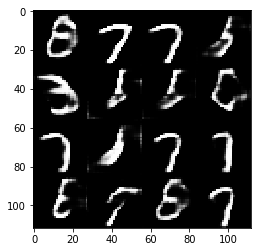

Epoch 2/2...Step 810 Discriminator Loss: 0.6532... Generator Loss: 2.1268
Epoch 2/2...Step 820 Discriminator Loss: 0.7630... Generator Loss: 1.5460
Epoch 2/2...Step 830 Discriminator Loss: 0.7373... Generator Loss: 2.3221
Epoch 2/2...Step 840 Discriminator Loss: 0.6806... Generator Loss: 2.0132
Epoch 2/2...Step 850 Discriminator Loss: 0.7257... Generator Loss: 1.8709
Epoch 2/2...Step 860 Discriminator Loss: 0.7366... Generator Loss: 2.5437
Epoch 2/2...Step 870 Discriminator Loss: 0.7867... Generator Loss: 2.7143
Epoch 2/2...Step 880 Discriminator Loss: 0.7800... Generator Loss: 1.9187
Epoch 2/2...Step 890 Discriminator Loss: 1.3480... Generator Loss: 0.7592
Epoch 2/2...Step 900 Discriminator Loss: 0.8211... Generator Loss: 2.4128


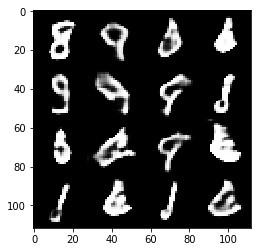

Epoch 2/2...Step 910 Discriminator Loss: 0.7891... Generator Loss: 1.9440
Epoch 2/2...Step 920 Discriminator Loss: 0.7995... Generator Loss: 3.2218
Epoch 2/2...Step 930 Discriminator Loss: 0.9018... Generator Loss: 1.1553


In [38]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...Step 10 Discriminator Loss: 2.2091... Generator Loss: 0.3661
Epoch 1/1...Step 20 Discriminator Loss: 0.4274... Generator Loss: 3.2740
Epoch 1/1...Step 30 Discriminator Loss: 0.6719... Generator Loss: 2.1516
Epoch 1/1...Step 40 Discriminator Loss: 0.4256... Generator Loss: 5.8669
Epoch 1/1...Step 50 Discriminator Loss: 0.9588... Generator Loss: 1.6258
Epoch 1/1...Step 60 Discriminator Loss: 0.4121... Generator Loss: 4.0180
Epoch 1/1...Step 70 Discriminator Loss: 0.5367... Generator Loss: 2.1419
Epoch 1/1...Step 80 Discriminator Loss: 0.9331... Generator Loss: 6.2765
Epoch 1/1...Step 90 Discriminator Loss: 0.4789... Generator Loss: 2.6266
Epoch 1/1...Step 100 Discriminator Loss: 0.6352... Generator Loss: 1.7488


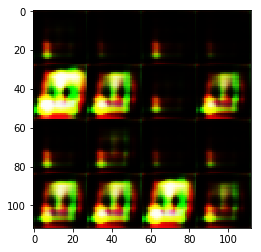

Epoch 1/1...Step 110 Discriminator Loss: 0.6900... Generator Loss: 1.5830
Epoch 1/1...Step 120 Discriminator Loss: 0.5974... Generator Loss: 2.6372
Epoch 1/1...Step 130 Discriminator Loss: 2.2118... Generator Loss: 4.0325
Epoch 1/1...Step 140 Discriminator Loss: 1.6354... Generator Loss: 0.4451
Epoch 1/1...Step 150 Discriminator Loss: 0.7717... Generator Loss: 1.8351
Epoch 1/1...Step 160 Discriminator Loss: 0.5592... Generator Loss: 2.2558
Epoch 1/1...Step 170 Discriminator Loss: 2.2670... Generator Loss: 6.0652
Epoch 1/1...Step 180 Discriminator Loss: 1.7430... Generator Loss: 0.5427
Epoch 1/1...Step 190 Discriminator Loss: 1.0621... Generator Loss: 0.9731
Epoch 1/1...Step 200 Discriminator Loss: 1.2290... Generator Loss: 0.6577


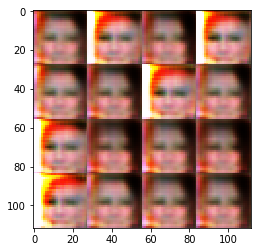

Epoch 1/1...Step 210 Discriminator Loss: 1.2153... Generator Loss: 3.1085
Epoch 1/1...Step 220 Discriminator Loss: 0.6964... Generator Loss: 1.8179
Epoch 1/1...Step 230 Discriminator Loss: 1.2933... Generator Loss: 0.6616
Epoch 1/1...Step 240 Discriminator Loss: 0.9061... Generator Loss: 1.7375
Epoch 1/1...Step 250 Discriminator Loss: 1.2521... Generator Loss: 0.5755
Epoch 1/1...Step 260 Discriminator Loss: 0.9357... Generator Loss: 1.7484
Epoch 1/1...Step 270 Discriminator Loss: 0.8139... Generator Loss: 1.2498
Epoch 1/1...Step 280 Discriminator Loss: 1.2061... Generator Loss: 0.9052
Epoch 1/1...Step 290 Discriminator Loss: 0.9027... Generator Loss: 1.1095
Epoch 1/1...Step 300 Discriminator Loss: 1.3198... Generator Loss: 2.8320


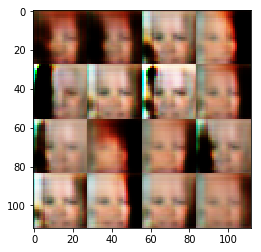

Epoch 1/1...Step 310 Discriminator Loss: 2.2569... Generator Loss: 0.1995
Epoch 1/1...Step 320 Discriminator Loss: 0.8423... Generator Loss: 1.4877
Epoch 1/1...Step 330 Discriminator Loss: 0.9886... Generator Loss: 1.2103
Epoch 1/1...Step 340 Discriminator Loss: 3.5106... Generator Loss: 4.8827
Epoch 1/1...Step 350 Discriminator Loss: 1.1249... Generator Loss: 1.0123
Epoch 1/1...Step 360 Discriminator Loss: 1.0998... Generator Loss: 1.2376
Epoch 1/1...Step 370 Discriminator Loss: 0.9664... Generator Loss: 1.1165
Epoch 1/1...Step 380 Discriminator Loss: 1.3138... Generator Loss: 0.6075
Epoch 1/1...Step 390 Discriminator Loss: 1.1230... Generator Loss: 1.0952
Epoch 1/1...Step 400 Discriminator Loss: 1.0625... Generator Loss: 2.0755


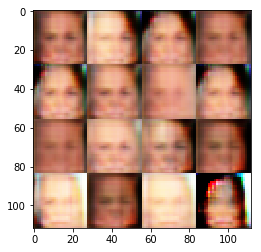

Epoch 1/1...Step 410 Discriminator Loss: 1.0687... Generator Loss: 1.2308
Epoch 1/1...Step 420 Discriminator Loss: 0.7155... Generator Loss: 1.5557
Epoch 1/1...Step 430 Discriminator Loss: 1.9578... Generator Loss: 4.9152
Epoch 1/1...Step 440 Discriminator Loss: 1.1614... Generator Loss: 1.0043
Epoch 1/1...Step 450 Discriminator Loss: 1.0798... Generator Loss: 0.8877
Epoch 1/1...Step 460 Discriminator Loss: 1.4373... Generator Loss: 0.6495
Epoch 1/1...Step 470 Discriminator Loss: 0.5761... Generator Loss: 2.3949
Epoch 1/1...Step 480 Discriminator Loss: 0.9026... Generator Loss: 1.3078
Epoch 1/1...Step 490 Discriminator Loss: 1.2020... Generator Loss: 0.7171
Epoch 1/1...Step 500 Discriminator Loss: 0.9944... Generator Loss: 1.5176


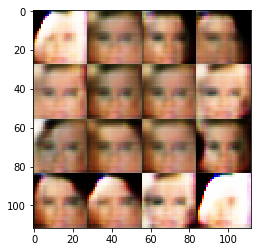

Epoch 1/1...Step 510 Discriminator Loss: 1.2307... Generator Loss: 0.6338
Epoch 1/1...Step 520 Discriminator Loss: 1.2096... Generator Loss: 1.1665
Epoch 1/1...Step 530 Discriminator Loss: 0.6634... Generator Loss: 1.6435
Epoch 1/1...Step 540 Discriminator Loss: 0.7053... Generator Loss: 1.7140
Epoch 1/1...Step 550 Discriminator Loss: 1.3828... Generator Loss: 3.8904
Epoch 1/1...Step 560 Discriminator Loss: 2.6475... Generator Loss: 0.2017
Epoch 1/1...Step 570 Discriminator Loss: 0.6043... Generator Loss: 1.9892
Epoch 1/1...Step 580 Discriminator Loss: 1.0402... Generator Loss: 0.8418
Epoch 1/1...Step 590 Discriminator Loss: 0.9058... Generator Loss: 1.6083
Epoch 1/1...Step 600 Discriminator Loss: 1.4690... Generator Loss: 3.4871


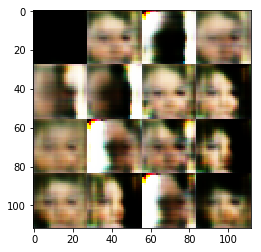

Epoch 1/1...Step 610 Discriminator Loss: 1.0215... Generator Loss: 1.0511
Epoch 1/1...Step 620 Discriminator Loss: 1.6566... Generator Loss: 0.4101
Epoch 1/1...Step 630 Discriminator Loss: 1.9172... Generator Loss: 4.7976
Epoch 1/1...Step 640 Discriminator Loss: 1.1580... Generator Loss: 1.5207
Epoch 1/1...Step 650 Discriminator Loss: 0.6903... Generator Loss: 1.5208
Epoch 1/1...Step 660 Discriminator Loss: 1.9835... Generator Loss: 0.3099
Epoch 1/1...Step 670 Discriminator Loss: 0.8833... Generator Loss: 1.5065
Epoch 1/1...Step 680 Discriminator Loss: 0.8326... Generator Loss: 1.1540
Epoch 1/1...Step 690 Discriminator Loss: 1.1765... Generator Loss: 0.7197
Epoch 1/1...Step 700 Discriminator Loss: 0.9431... Generator Loss: 2.8708


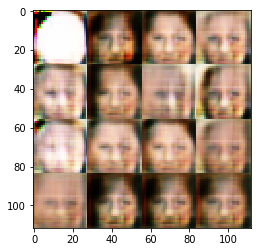

Epoch 1/1...Step 710 Discriminator Loss: 1.2026... Generator Loss: 0.7238
Epoch 1/1...Step 720 Discriminator Loss: 0.9270... Generator Loss: 1.0879
Epoch 1/1...Step 730 Discriminator Loss: 0.8990... Generator Loss: 1.2053
Epoch 1/1...Step 740 Discriminator Loss: 0.6821... Generator Loss: 2.0572
Epoch 1/1...Step 750 Discriminator Loss: 0.7703... Generator Loss: 1.9172
Epoch 1/1...Step 760 Discriminator Loss: 1.8166... Generator Loss: 0.3583
Epoch 1/1...Step 770 Discriminator Loss: 0.9235... Generator Loss: 2.8242
Epoch 1/1...Step 780 Discriminator Loss: 0.7325... Generator Loss: 1.5156
Epoch 1/1...Step 790 Discriminator Loss: 1.0857... Generator Loss: 0.7537
Epoch 1/1...Step 800 Discriminator Loss: 0.7153... Generator Loss: 1.9395


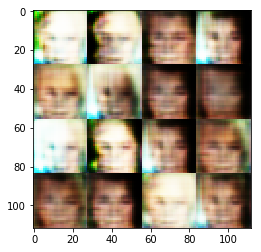

Epoch 1/1...Step 810 Discriminator Loss: 0.6765... Generator Loss: 2.4177
Epoch 1/1...Step 820 Discriminator Loss: 0.6153... Generator Loss: 1.9963
Epoch 1/1...Step 830 Discriminator Loss: 0.7712... Generator Loss: 1.8495
Epoch 1/1...Step 840 Discriminator Loss: 0.9699... Generator Loss: 2.5428
Epoch 1/1...Step 850 Discriminator Loss: 0.9642... Generator Loss: 1.2848
Epoch 1/1...Step 860 Discriminator Loss: 0.7933... Generator Loss: 1.5082
Epoch 1/1...Step 870 Discriminator Loss: 0.8320... Generator Loss: 1.3128
Epoch 1/1...Step 880 Discriminator Loss: 1.0042... Generator Loss: 2.5743
Epoch 1/1...Step 890 Discriminator Loss: 0.8485... Generator Loss: 2.4762
Epoch 1/1...Step 900 Discriminator Loss: 0.6903... Generator Loss: 1.9644


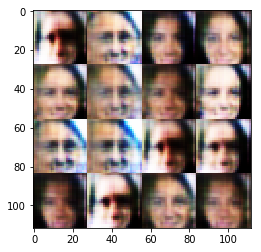

Epoch 1/1...Step 910 Discriminator Loss: 1.5007... Generator Loss: 0.4903
Epoch 1/1...Step 920 Discriminator Loss: 0.9495... Generator Loss: 1.2415
Epoch 1/1...Step 930 Discriminator Loss: 1.2355... Generator Loss: 0.6718
Epoch 1/1...Step 940 Discriminator Loss: 0.7012... Generator Loss: 1.7276
Epoch 1/1...Step 950 Discriminator Loss: 0.7071... Generator Loss: 2.2706
Epoch 1/1...Step 960 Discriminator Loss: 0.8891... Generator Loss: 1.7339
Epoch 1/1...Step 970 Discriminator Loss: 0.6186... Generator Loss: 2.0026
Epoch 1/1...Step 980 Discriminator Loss: 1.0990... Generator Loss: 0.8077
Epoch 1/1...Step 990 Discriminator Loss: 0.9449... Generator Loss: 1.1912
Epoch 1/1...Step 1000 Discriminator Loss: 1.6272... Generator Loss: 0.4171


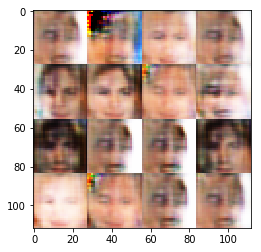

Epoch 1/1...Step 1010 Discriminator Loss: 0.7899... Generator Loss: 1.3167
Epoch 1/1...Step 1020 Discriminator Loss: 0.7953... Generator Loss: 2.1642
Epoch 1/1...Step 1030 Discriminator Loss: 0.8959... Generator Loss: 1.3247
Epoch 1/1...Step 1040 Discriminator Loss: 0.9909... Generator Loss: 1.8197
Epoch 1/1...Step 1050 Discriminator Loss: 0.7431... Generator Loss: 2.1352
Epoch 1/1...Step 1060 Discriminator Loss: 1.0296... Generator Loss: 0.9093
Epoch 1/1...Step 1070 Discriminator Loss: 1.0396... Generator Loss: 1.0543
Epoch 1/1...Step 1080 Discriminator Loss: 1.1627... Generator Loss: 1.4155
Epoch 1/1...Step 1090 Discriminator Loss: 1.1084... Generator Loss: 0.8689
Epoch 1/1...Step 1100 Discriminator Loss: 0.7893... Generator Loss: 2.3067


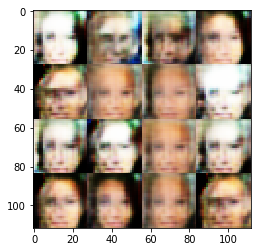

Epoch 1/1...Step 1110 Discriminator Loss: 0.6459... Generator Loss: 2.5249
Epoch 1/1...Step 1120 Discriminator Loss: 0.9033... Generator Loss: 0.9686
Epoch 1/1...Step 1130 Discriminator Loss: 1.0537... Generator Loss: 0.8288
Epoch 1/1...Step 1140 Discriminator Loss: 1.3605... Generator Loss: 0.6310
Epoch 1/1...Step 1150 Discriminator Loss: 1.1059... Generator Loss: 1.6475
Epoch 1/1...Step 1160 Discriminator Loss: 0.8310... Generator Loss: 1.1906
Epoch 1/1...Step 1170 Discriminator Loss: 0.8535... Generator Loss: 1.6645
Epoch 1/1...Step 1180 Discriminator Loss: 1.6717... Generator Loss: 0.6119
Epoch 1/1...Step 1190 Discriminator Loss: 0.7659... Generator Loss: 1.6190
Epoch 1/1...Step 1200 Discriminator Loss: 1.0507... Generator Loss: 0.9232


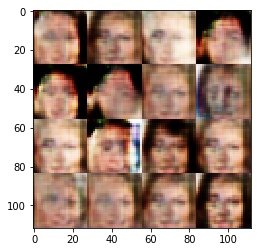

Epoch 1/1...Step 1210 Discriminator Loss: 1.5293... Generator Loss: 0.4436
Epoch 1/1...Step 1220 Discriminator Loss: 0.8634... Generator Loss: 1.7565
Epoch 1/1...Step 1230 Discriminator Loss: 1.9347... Generator Loss: 0.2967
Epoch 1/1...Step 1240 Discriminator Loss: 0.7615... Generator Loss: 2.0734
Epoch 1/1...Step 1250 Discriminator Loss: 0.6799... Generator Loss: 2.5485
Epoch 1/1...Step 1260 Discriminator Loss: 1.0565... Generator Loss: 0.8335
Epoch 1/1...Step 1270 Discriminator Loss: 1.1286... Generator Loss: 0.8500
Epoch 1/1...Step 1280 Discriminator Loss: 0.4513... Generator Loss: 3.2253
Epoch 1/1...Step 1290 Discriminator Loss: 2.0906... Generator Loss: 0.2964
Epoch 1/1...Step 1300 Discriminator Loss: 0.8897... Generator Loss: 3.4015


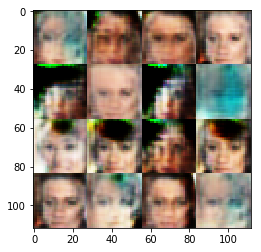

Epoch 1/1...Step 1310 Discriminator Loss: 0.7669... Generator Loss: 1.7737
Epoch 1/1...Step 1320 Discriminator Loss: 0.9782... Generator Loss: 2.8457
Epoch 1/1...Step 1330 Discriminator Loss: 0.7162... Generator Loss: 2.6134
Epoch 1/1...Step 1340 Discriminator Loss: 1.0598... Generator Loss: 0.7825
Epoch 1/1...Step 1350 Discriminator Loss: 1.1521... Generator Loss: 2.7835
Epoch 1/1...Step 1360 Discriminator Loss: 1.0051... Generator Loss: 0.9690
Epoch 1/1...Step 1370 Discriminator Loss: 0.7121... Generator Loss: 1.5320
Epoch 1/1...Step 1380 Discriminator Loss: 1.0877... Generator Loss: 0.9920
Epoch 1/1...Step 1390 Discriminator Loss: 0.8011... Generator Loss: 1.3177
Epoch 1/1...Step 1400 Discriminator Loss: 1.2082... Generator Loss: 0.7131


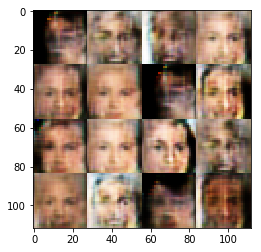

Epoch 1/1...Step 1410 Discriminator Loss: 0.8773... Generator Loss: 1.2390
Epoch 1/1...Step 1420 Discriminator Loss: 1.9657... Generator Loss: 0.3593
Epoch 1/1...Step 1430 Discriminator Loss: 0.8489... Generator Loss: 2.5274
Epoch 1/1...Step 1440 Discriminator Loss: 1.0468... Generator Loss: 1.0164
Epoch 1/1...Step 1450 Discriminator Loss: 0.6938... Generator Loss: 1.7167
Epoch 1/1...Step 1460 Discriminator Loss: 1.1312... Generator Loss: 1.3739
Epoch 1/1...Step 1470 Discriminator Loss: 0.9126... Generator Loss: 1.0350
Epoch 1/1...Step 1480 Discriminator Loss: 0.6209... Generator Loss: 1.9675
Epoch 1/1...Step 1490 Discriminator Loss: 1.9432... Generator Loss: 0.3339
Epoch 1/1...Step 1500 Discriminator Loss: 2.1132... Generator Loss: 0.2364


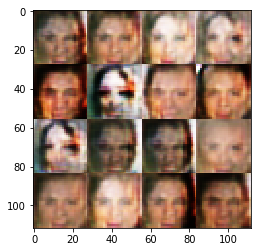

Epoch 1/1...Step 1510 Discriminator Loss: 0.8001... Generator Loss: 1.4234
Epoch 1/1...Step 1520 Discriminator Loss: 0.9898... Generator Loss: 1.2592
Epoch 1/1...Step 1530 Discriminator Loss: 0.9828... Generator Loss: 2.3476
Epoch 1/1...Step 1540 Discriminator Loss: 0.8387... Generator Loss: 1.7450
Epoch 1/1...Step 1550 Discriminator Loss: 0.9980... Generator Loss: 0.9261
Epoch 1/1...Step 1560 Discriminator Loss: 0.8708... Generator Loss: 2.0638
Epoch 1/1...Step 1570 Discriminator Loss: 1.0536... Generator Loss: 1.8135
Epoch 1/1...Step 1580 Discriminator Loss: 1.0025... Generator Loss: 0.9422
Epoch 1/1...Step 1590 Discriminator Loss: 0.9503... Generator Loss: 1.1363
Epoch 1/1...Step 1600 Discriminator Loss: 0.8850... Generator Loss: 2.4237


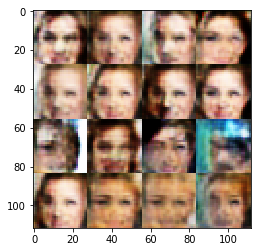

Epoch 1/1...Step 1610 Discriminator Loss: 0.7431... Generator Loss: 1.6299
Epoch 1/1...Step 1620 Discriminator Loss: 0.9519... Generator Loss: 1.4976
Epoch 1/1...Step 1630 Discriminator Loss: 0.9797... Generator Loss: 0.9478
Epoch 1/1...Step 1640 Discriminator Loss: 1.0046... Generator Loss: 2.6946
Epoch 1/1...Step 1650 Discriminator Loss: 0.8659... Generator Loss: 2.1797
Epoch 1/1...Step 1660 Discriminator Loss: 0.8071... Generator Loss: 1.9437
Epoch 1/1...Step 1670 Discriminator Loss: 1.4320... Generator Loss: 0.6928
Epoch 1/1...Step 1680 Discriminator Loss: 0.9063... Generator Loss: 1.0600
Epoch 1/1...Step 1690 Discriminator Loss: 1.2948... Generator Loss: 0.5677
Epoch 1/1...Step 1700 Discriminator Loss: 0.9526... Generator Loss: 1.1412


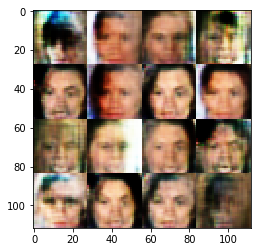

Epoch 1/1...Step 1710 Discriminator Loss: 0.8652... Generator Loss: 1.1124
Epoch 1/1...Step 1720 Discriminator Loss: 1.2104... Generator Loss: 3.2081
Epoch 1/1...Step 1730 Discriminator Loss: 0.8596... Generator Loss: 1.3171
Epoch 1/1...Step 1740 Discriminator Loss: 1.0835... Generator Loss: 1.0285
Epoch 1/1...Step 1750 Discriminator Loss: 1.1636... Generator Loss: 0.6663
Epoch 1/1...Step 1760 Discriminator Loss: 1.0195... Generator Loss: 1.0295
Epoch 1/1...Step 1770 Discriminator Loss: 0.9177... Generator Loss: 1.9818
Epoch 1/1...Step 1780 Discriminator Loss: 1.1537... Generator Loss: 0.7985
Epoch 1/1...Step 1790 Discriminator Loss: 1.1719... Generator Loss: 0.6940
Epoch 1/1...Step 1800 Discriminator Loss: 1.7123... Generator Loss: 3.6359


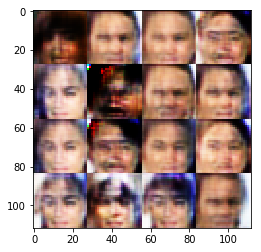

Epoch 1/1...Step 1810 Discriminator Loss: 0.6691... Generator Loss: 2.8636
Epoch 1/1...Step 1820 Discriminator Loss: 0.7227... Generator Loss: 1.8421
Epoch 1/1...Step 1830 Discriminator Loss: 1.2997... Generator Loss: 0.6613
Epoch 1/1...Step 1840 Discriminator Loss: 0.9041... Generator Loss: 2.1949
Epoch 1/1...Step 1850 Discriminator Loss: 0.7824... Generator Loss: 1.6591
Epoch 1/1...Step 1860 Discriminator Loss: 0.8415... Generator Loss: 1.6798
Epoch 1/1...Step 1870 Discriminator Loss: 0.9905... Generator Loss: 1.4526
Epoch 1/1...Step 1880 Discriminator Loss: 0.7114... Generator Loss: 1.9339
Epoch 1/1...Step 1890 Discriminator Loss: 1.2763... Generator Loss: 0.8042
Epoch 1/1...Step 1900 Discriminator Loss: 1.1600... Generator Loss: 0.8262


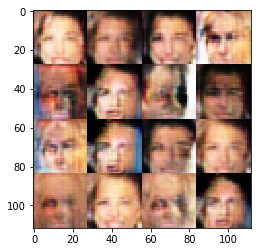

Epoch 1/1...Step 1910 Discriminator Loss: 1.2973... Generator Loss: 0.6563
Epoch 1/1...Step 1920 Discriminator Loss: 0.9643... Generator Loss: 0.9861
Epoch 1/1...Step 1930 Discriminator Loss: 1.1044... Generator Loss: 2.7565
Epoch 1/1...Step 1940 Discriminator Loss: 0.7731... Generator Loss: 1.5917
Epoch 1/1...Step 1950 Discriminator Loss: 1.0748... Generator Loss: 0.8441
Epoch 1/1...Step 1960 Discriminator Loss: 0.7639... Generator Loss: 2.1974
Epoch 1/1...Step 1970 Discriminator Loss: 0.7447... Generator Loss: 1.6470
Epoch 1/1...Step 1980 Discriminator Loss: 0.6155... Generator Loss: 3.1109
Epoch 1/1...Step 1990 Discriminator Loss: 1.6605... Generator Loss: 0.4224
Epoch 1/1...Step 2000 Discriminator Loss: 1.0623... Generator Loss: 0.9068


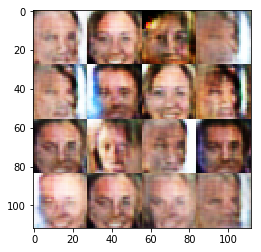

Epoch 1/1...Step 2010 Discriminator Loss: 0.8416... Generator Loss: 2.0562
Epoch 1/1...Step 2020 Discriminator Loss: 1.1925... Generator Loss: 3.1239
Epoch 1/1...Step 2030 Discriminator Loss: 0.9992... Generator Loss: 0.9866
Epoch 1/1...Step 2040 Discriminator Loss: 0.9940... Generator Loss: 1.0640
Epoch 1/1...Step 2050 Discriminator Loss: 0.9751... Generator Loss: 1.0810
Epoch 1/1...Step 2060 Discriminator Loss: 0.7428... Generator Loss: 1.5648
Epoch 1/1...Step 2070 Discriminator Loss: 0.9544... Generator Loss: 2.6327
Epoch 1/1...Step 2080 Discriminator Loss: 1.1943... Generator Loss: 0.7464
Epoch 1/1...Step 2090 Discriminator Loss: 1.0467... Generator Loss: 1.0140
Epoch 1/1...Step 2100 Discriminator Loss: 0.7282... Generator Loss: 1.7064


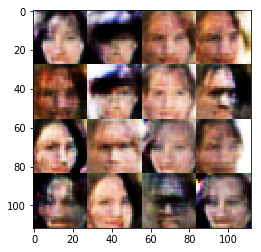

Epoch 1/1...Step 2110 Discriminator Loss: 1.1841... Generator Loss: 0.7035
Epoch 1/1...Step 2120 Discriminator Loss: 1.0154... Generator Loss: 1.0962
Epoch 1/1...Step 2130 Discriminator Loss: 1.0296... Generator Loss: 0.9270
Epoch 1/1...Step 2140 Discriminator Loss: 0.9822... Generator Loss: 1.4788
Epoch 1/1...Step 2150 Discriminator Loss: 0.8396... Generator Loss: 1.1692
Epoch 1/1...Step 2160 Discriminator Loss: 0.7256... Generator Loss: 1.7439
Epoch 1/1...Step 2170 Discriminator Loss: 1.4801... Generator Loss: 0.6062
Epoch 1/1...Step 2180 Discriminator Loss: 0.7262... Generator Loss: 1.6384
Epoch 1/1...Step 2190 Discriminator Loss: 0.9699... Generator Loss: 1.0554
Epoch 1/1...Step 2200 Discriminator Loss: 0.7568... Generator Loss: 1.4490


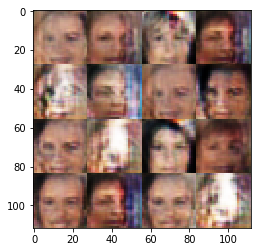

Epoch 1/1...Step 2210 Discriminator Loss: 0.9947... Generator Loss: 1.1356
Epoch 1/1...Step 2220 Discriminator Loss: 1.3742... Generator Loss: 0.5629
Epoch 1/1...Step 2230 Discriminator Loss: 1.0492... Generator Loss: 1.6449
Epoch 1/1...Step 2240 Discriminator Loss: 0.8425... Generator Loss: 1.4754
Epoch 1/1...Step 2250 Discriminator Loss: 0.7971... Generator Loss: 1.4476
Epoch 1/1...Step 2260 Discriminator Loss: 0.8627... Generator Loss: 1.2002
Epoch 1/1...Step 2270 Discriminator Loss: 0.8149... Generator Loss: 1.8243
Epoch 1/1...Step 2280 Discriminator Loss: 0.9827... Generator Loss: 1.3625
Epoch 1/1...Step 2290 Discriminator Loss: 1.3504... Generator Loss: 3.1324
Epoch 1/1...Step 2300 Discriminator Loss: 0.9319... Generator Loss: 1.2441


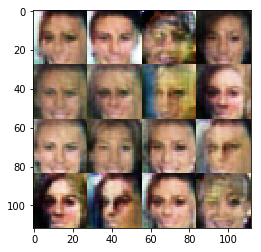

Epoch 1/1...Step 2310 Discriminator Loss: 0.7810... Generator Loss: 1.9045
Epoch 1/1...Step 2320 Discriminator Loss: 1.0001... Generator Loss: 1.6562
Epoch 1/1...Step 2330 Discriminator Loss: 1.1708... Generator Loss: 0.7629
Epoch 1/1...Step 2340 Discriminator Loss: 0.6618... Generator Loss: 1.9558
Epoch 1/1...Step 2350 Discriminator Loss: 0.7543... Generator Loss: 1.6394
Epoch 1/1...Step 2360 Discriminator Loss: 0.7062... Generator Loss: 1.5186
Epoch 1/1...Step 2370 Discriminator Loss: 1.1371... Generator Loss: 0.8401
Epoch 1/1...Step 2380 Discriminator Loss: 0.7063... Generator Loss: 3.3351
Epoch 1/1...Step 2390 Discriminator Loss: 0.8757... Generator Loss: 2.0644
Epoch 1/1...Step 2400 Discriminator Loss: 1.7231... Generator Loss: 4.1336


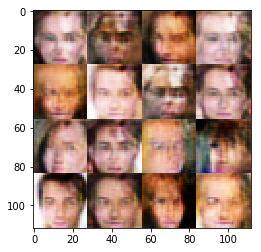

Epoch 1/1...Step 2410 Discriminator Loss: 0.9636... Generator Loss: 2.4890
Epoch 1/1...Step 2420 Discriminator Loss: 0.7924... Generator Loss: 1.4748
Epoch 1/1...Step 2430 Discriminator Loss: 0.8554... Generator Loss: 1.4089
Epoch 1/1...Step 2440 Discriminator Loss: 0.7428... Generator Loss: 1.8177
Epoch 1/1...Step 2450 Discriminator Loss: 0.9200... Generator Loss: 1.1026
Epoch 1/1...Step 2460 Discriminator Loss: 1.2806... Generator Loss: 3.5208
Epoch 1/1...Step 2470 Discriminator Loss: 0.8933... Generator Loss: 1.2855
Epoch 1/1...Step 2480 Discriminator Loss: 0.6844... Generator Loss: 2.0326
Epoch 1/1...Step 2490 Discriminator Loss: 0.9230... Generator Loss: 1.1508
Epoch 1/1...Step 2500 Discriminator Loss: 0.9487... Generator Loss: 1.1890


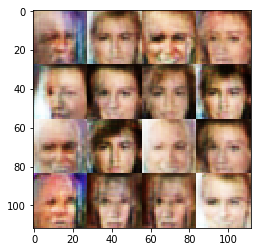

Epoch 1/1...Step 2510 Discriminator Loss: 0.7835... Generator Loss: 1.8265
Epoch 1/1...Step 2520 Discriminator Loss: 1.0516... Generator Loss: 0.9444
Epoch 1/1...Step 2530 Discriminator Loss: 0.9954... Generator Loss: 1.1122
Epoch 1/1...Step 2540 Discriminator Loss: 0.8737... Generator Loss: 1.5439
Epoch 1/1...Step 2550 Discriminator Loss: 0.6607... Generator Loss: 2.1429
Epoch 1/1...Step 2560 Discriminator Loss: 0.8908... Generator Loss: 1.4652
Epoch 1/1...Step 2570 Discriminator Loss: 0.8473... Generator Loss: 1.3644
Epoch 1/1...Step 2580 Discriminator Loss: 0.6960... Generator Loss: 1.9106
Epoch 1/1...Step 2590 Discriminator Loss: 0.8601... Generator Loss: 1.6275
Epoch 1/1...Step 2600 Discriminator Loss: 0.7099... Generator Loss: 1.6207


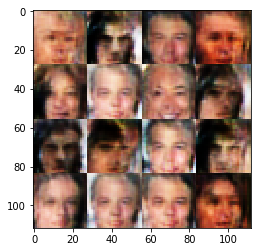

Epoch 1/1...Step 2610 Discriminator Loss: 0.8768... Generator Loss: 1.6454
Epoch 1/1...Step 2620 Discriminator Loss: 0.8257... Generator Loss: 2.1715
Epoch 1/1...Step 2630 Discriminator Loss: 0.6784... Generator Loss: 1.9085
Epoch 1/1...Step 2640 Discriminator Loss: 0.8875... Generator Loss: 1.1457
Epoch 1/1...Step 2650 Discriminator Loss: 0.8590... Generator Loss: 1.2214
Epoch 1/1...Step 2660 Discriminator Loss: 0.7327... Generator Loss: 1.7403
Epoch 1/1...Step 2670 Discriminator Loss: 0.7629... Generator Loss: 1.6755
Epoch 1/1...Step 2680 Discriminator Loss: 1.1940... Generator Loss: 0.7300
Epoch 1/1...Step 2690 Discriminator Loss: 1.2069... Generator Loss: 0.6849
Epoch 1/1...Step 2700 Discriminator Loss: 0.9019... Generator Loss: 1.8492


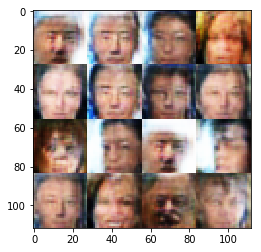

Epoch 1/1...Step 2710 Discriminator Loss: 0.8002... Generator Loss: 1.4816
Epoch 1/1...Step 2720 Discriminator Loss: 1.1455... Generator Loss: 0.8676
Epoch 1/1...Step 2730 Discriminator Loss: 0.7993... Generator Loss: 2.3968
Epoch 1/1...Step 2740 Discriminator Loss: 0.8154... Generator Loss: 1.3536
Epoch 1/1...Step 2750 Discriminator Loss: 1.0765... Generator Loss: 0.8857
Epoch 1/1...Step 2760 Discriminator Loss: 0.9766... Generator Loss: 0.9295
Epoch 1/1...Step 2770 Discriminator Loss: 0.9945... Generator Loss: 1.0028
Epoch 1/1...Step 2780 Discriminator Loss: 1.1412... Generator Loss: 0.7589
Epoch 1/1...Step 2790 Discriminator Loss: 1.4321... Generator Loss: 0.5252
Epoch 1/1...Step 2800 Discriminator Loss: 0.8193... Generator Loss: 2.2648


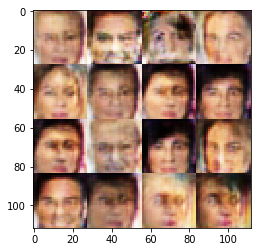

Epoch 1/1...Step 2810 Discriminator Loss: 0.9856... Generator Loss: 0.9764
Epoch 1/1...Step 2820 Discriminator Loss: 1.4119... Generator Loss: 0.5399
Epoch 1/1...Step 2830 Discriminator Loss: 1.3656... Generator Loss: 0.6364
Epoch 1/1...Step 2840 Discriminator Loss: 0.8647... Generator Loss: 1.3143
Epoch 1/1...Step 2850 Discriminator Loss: 1.2281... Generator Loss: 0.6804
Epoch 1/1...Step 2860 Discriminator Loss: 0.8583... Generator Loss: 1.1833
Epoch 1/1...Step 2870 Discriminator Loss: 1.0754... Generator Loss: 2.3932
Epoch 1/1...Step 2880 Discriminator Loss: 1.0221... Generator Loss: 1.0485
Epoch 1/1...Step 2890 Discriminator Loss: 1.1088... Generator Loss: 0.8421
Epoch 1/1...Step 2900 Discriminator Loss: 0.8900... Generator Loss: 1.2049


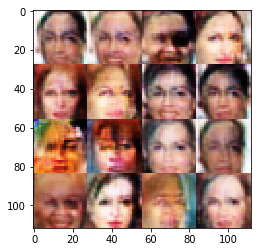

Epoch 1/1...Step 2910 Discriminator Loss: 1.1661... Generator Loss: 0.7898
Epoch 1/1...Step 2920 Discriminator Loss: 0.8900... Generator Loss: 1.1927
Epoch 1/1...Step 2930 Discriminator Loss: 0.8106... Generator Loss: 1.3675
Epoch 1/1...Step 2940 Discriminator Loss: 0.8739... Generator Loss: 2.3360
Epoch 1/1...Step 2950 Discriminator Loss: 0.8272... Generator Loss: 2.0120
Epoch 1/1...Step 2960 Discriminator Loss: 0.9812... Generator Loss: 0.9101
Epoch 1/1...Step 2970 Discriminator Loss: 0.9198... Generator Loss: 1.1714
Epoch 1/1...Step 2980 Discriminator Loss: 1.1367... Generator Loss: 0.8089
Epoch 1/1...Step 2990 Discriminator Loss: 0.8057... Generator Loss: 1.8940
Epoch 1/1...Step 3000 Discriminator Loss: 0.8251... Generator Loss: 1.5168


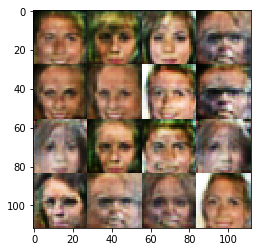

Epoch 1/1...Step 3010 Discriminator Loss: 0.8476... Generator Loss: 1.3851
Epoch 1/1...Step 3020 Discriminator Loss: 1.0492... Generator Loss: 0.8869
Epoch 1/1...Step 3030 Discriminator Loss: 0.8346... Generator Loss: 2.4500
Epoch 1/1...Step 3040 Discriminator Loss: 0.8098... Generator Loss: 1.3778
Epoch 1/1...Step 3050 Discriminator Loss: 0.8137... Generator Loss: 1.8764
Epoch 1/1...Step 3060 Discriminator Loss: 0.8730... Generator Loss: 2.1090
Epoch 1/1...Step 3070 Discriminator Loss: 0.8588... Generator Loss: 1.1568
Epoch 1/1...Step 3080 Discriminator Loss: 0.9263... Generator Loss: 2.1028
Epoch 1/1...Step 3090 Discriminator Loss: 1.0123... Generator Loss: 0.9445
Epoch 1/1...Step 3100 Discriminator Loss: 0.8875... Generator Loss: 1.7300


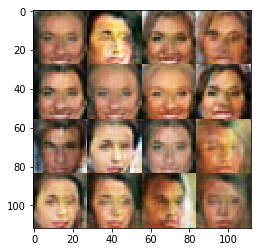

Epoch 1/1...Step 3110 Discriminator Loss: 0.8298... Generator Loss: 2.2369
Epoch 1/1...Step 3120 Discriminator Loss: 0.7280... Generator Loss: 1.6908
Epoch 1/1...Step 3130 Discriminator Loss: 1.2612... Generator Loss: 3.2631
Epoch 1/1...Step 3140 Discriminator Loss: 0.8513... Generator Loss: 1.1955
Epoch 1/1...Step 3150 Discriminator Loss: 0.8417... Generator Loss: 1.9335
Epoch 1/1...Step 3160 Discriminator Loss: 0.8502... Generator Loss: 1.4119


In [42]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.